# Optimisation topologique linéaire

In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.geom2d import CSG2d, Circle, Rectangle
from copy import copy
import numpy as np
import matplotlib.pyplot as plt

importing NGSolve-6.2.2105-9-g5a835126f


## 1) Définition du maillage

In [3]:
def generate_fitted_circle_mesh(N):
    geo = CSG2d()
    R=1
    x = R*2*(np.append(np.insert(np.arange(0.5,N+0.5),0,0),N)/N-0.5)
    
    circle1 = Circle( center=(0,0), radius=R, bc="left_up" ) * Rectangle( pmin=(-R,0), pmax=(0,R))
    circle2 = Circle( center=(0,0), radius=R, bc="left_bot" ) * Rectangle( pmin=(-R,-R), pmax=(0,0))
    circle3 = Circle( center=(0,0), radius=R, bc="right_bot" ) * Rectangle( pmin=(0,-R), pmax=(R,0))
    circle4 = Circle( center=(0,0), radius=R, bc="right_up" ) * Rectangle( pmin=(0,0), pmax=(R,R))
    
    materials = ["iron","air"]
    
    for i in range(len(x)-1):
        geo.Add(Rectangle( pmin=(x[i],-R), pmax=(x[i+1],R), mat = materials[i%2] ) * (circle1 + circle2 + circle3 +circle4))

    #m = geo.GenerateMesh(maxh=max([R/N,1/30])) # On doit fixer la taille du maillage sinon le volume change à cause des elts grossiers
    m = geo.GenerateMesh(maxh=1/N)
    return Mesh(m)

#Draw (mesh)

## 2) Définition des problèmes éléments finis

In [2]:
beta = 1;

def solvePb(mu,mesh):
    fespace_H1 = H1(mesh, order=1)
    fespace_H1.FreeDofs()[0] = False
    phi = fespace_H1.TrialFunction()
    psi = fespace_H1.TestFunction()
    K = BilinearForm(fespace_H1, symmetric=True)
    K +=  InnerProduct(grad(psi),mu*grad(phi))*dx

    n= specialcf.normal(mesh.dim);
    
    l1 = LinearForm(fespace_H1)
    l1 += -psi* beta * sqrt(1-x*x)* ds(definedon=mesh.Boundaries("right_bot|left_bot"))
    l1 += psi*beta* sqrt(1-x*x)*ds(definedon=mesh.Boundaries("right_up|left_up"))

    l2 = LinearForm(fespace_H1)
    l2 += -psi*beta*sqrt(1-y*y)*ds(definedon=mesh.Boundaries("right_bot|right_up"))
    l2 += psi*beta*sqrt(1-y*y)*ds(definedon=mesh.Boundaries("left_bot|left_up"))
    
    K.Assemble()
    l1.Assemble()
    l2.Assemble()
    
    phi1 = GridFunction(fespace_H1)  # solution
    phi1.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l1.vec
    phi2 = GridFunction(fespace_H1)  # solution
    phi2.vec.data =     K.mat.Inverse(inverse="sparsecholesky") * l2.vec
    
    return(phi1, phi2)

## 3) Optimisation

Le problème est auto-adjoint. Ainsi, l'adjoint s'écrit $\psi = -\phi$ et l'identification $\mathcal{L}^2$ du gradient par rapport à $\mu$ s'écrit:
$$\partial_\mu \mathcal{L} = -\int_\Omega |\nabla \phi|^2 $$

In [8]:
def gradient(phi1,phi2):
    return(-grad(phi1)*grad(phi1) + grad(phi2)*grad(phi2))

def compliance(phi,mu,mesh):
    return Integrate(grad(phi)*mu* grad(phi), mesh) /2

In [9]:
mur = np.logspace(0.1,4,20)
mu0 = 4e-7*3.14
Nmesh = 40;
resultMU= []
resultJ = []
resultJpar = []
resultJser = []

for j in range(len(mur)):
    fespace_mu = L2(mesh, order=0)    
    mu = GridFunction(fespace_mu)
    mu.Set(mur(j)/2*mu0);
    J=[]
    step = (mu_max-mu0)/10
    g = GridFunction(fespace_mu)
    MU=[]
    for i in range(1000):
        phi1, phi2 = solvePb(mu,mesh)
        g.Set(gradient(phi1,phi2))
        g.vec[:]= np.sign(g.vec[:].FV().NumPy())
        resultJpar = compliance(phi1,mu,mesh)
        resultJser.append() = compliance(phi1,mu,mesh)
        resultJ.append(objective(phi1,phi2,mu))
        MU.append(copy(mu))
        
        if i>0 and J[-1]< J[-2]:
            step = step*1.2
        elif i>0:
            step = step/2
        
        mu.Set(MU[i] - g*step)
        mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()<mu0]=mu0
        mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()>mu_max]=mu_max
        if np.isnan(np.sum(mu.vec[:].FV().NumPy())):
            break
        if step/(mu_max-mu0) < 1e-4:
            break
    resultMU.append(copy(MU[-2]))
    lastJ.append(copy(J[-2]))
        print(f'{lastJ[-1]} - mu_r = {mur[j]} - mesh = 1/{N}')
    resultJ.append(copy(lastJ))
    resultMU.append(copy(lastMU))

for k in range(len(Nmesh)):
    lastMU = []
    lastJ = []
    N = Nmesh[k]
    mesh = generate_fitted_circle_mesh(N)

    for j in range(len(mur)):
        fespace_mu = L2(mesh, order=0)    
        mu = GridFunction(fespace_mu)
        s = randint(3, size=len(mu.vec[:].FV()))-1
        #mu.vec[:]= 4e-7*3.14*(2+s[:]) # situation initiale aléatoire
        mu.vec[:]= 4e-7*3.14*1.5 # situation initiale uniforme
        J=[]
        mu0 = 4e-7*3.14
        mu_max = mur[j]* mu0
        step = (mu_max-mu0)/3
        g = GridFunction(fespace_mu)
        MU=[]
        for i in range(1000):
            phi1, phi2 = solvePb(mu,mesh)
            g.Set(gradient(phi1,phi2))
            g.vec[:]= np.sign(g.vec[:].FV().NumPy())
            J.append(objective(phi1,phi2,mu))
            MU.append(copy(mu))
        
            if i>0 and J[-1]< J[-2]:
                step = step*1.2
            elif i>0:
                step = step/2
        
            mu.Set(MU[i] - g*step)
            mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()<mu0]=mu0
            mu.vec[:].FV().NumPy()[mu.vec[:].FV().NumPy()>mu_max]=mu_max
            if np.isnan(np.sum(mu.vec[:].FV().NumPy())):
                break
            if step/(mu_max-mu0) < 1e-4:
                break
        lastMU.append(copy(MU[-2]))
        lastJ.append(copy(J[-2]))
        print(f'{lastJ[-1]} - mu_r = {mur[j]} - mesh = 1/{N}')
    resultJ.append(copy(lastJ))
    resultMU.append(copy(lastMU))

-23714.93745705127 - mu_r = 1.2589254117941673 - mesh = 1/10
-120984.57711523931 - mu_r = 1.7890874899232194 - mesh = 1/10
-235611.73174910533 - mu_r = 2.542512857880971 - mesh = 1/10
-424899.84269052144 - mu_r = 3.6132227567962514 - mesh = 1/10
-149990.55310021198 - mu_r = 5.134832907437552 - mesh = 1/10
-720962.5805503816 - mu_r = 7.297227644686393 - mesh = 1/10
-822638.3402792383 - mu_r = 10.370255908667641 - mesh = 1/10
-860433.6244734006 - mu_r = 14.737406155824797 - mesh = 1/10
-997130.7701825574 - mu_r = 20.943662539726763 - mesh = 1/10
-1058520.528570489 - mu_r = 29.763514416313193 - mesh = 1/10
-1024653.9085061894 - mu_r = 42.297606196133856 - mesh = 1/10
-1111355.8325746795 - mu_r = 60.11008864405587 - mesh = 1/10
-1086588.08322199 - mu_r = 85.42381193020124 - mesh = 1/10
-1073319.9851902607 - mu_r = 121.3977189070074 - mesh = 1/10
-1095753.92111032 - mu_r = 172.5210549942041 - mesh = 1/10
-1115346.8237594229 - mu_r = 245.17358879792891 - mesh = 1/10
-1165058.528594216 - mu_r

no more timer available, reusing last one


-1100908.2784967462 - mu_r = 703.6690038273064 - mesh = 1/10
-952339.2913990734 - mu_r = 1000.0 - mesh = 1/10
-20787.817038852943 - mu_r = 1.2589254117941673 - mesh = 1/20
-127331.71705000936 - mu_r = 1.7890874899232194 - mesh = 1/20
-288967.781669348 - mu_r = 2.542512857880971 - mesh = 1/20
-465310.795182862 - mu_r = 3.6132227567962514 - mesh = 1/20
-626887.6825136257 - mu_r = 5.134832907437552 - mesh = 1/20
-811103.1525193715 - mu_r = 7.297227644686393 - mesh = 1/20
-918587.4064944437 - mu_r = 10.370255908667641 - mesh = 1/20
-1035056.3824897081 - mu_r = 14.737406155824797 - mesh = 1/20
-1110044.024663784 - mu_r = 20.943662539726763 - mesh = 1/20
-1154554.3133438583 - mu_r = 29.763514416313193 - mesh = 1/20
-1220863.9474136506 - mu_r = 42.297606196133856 - mesh = 1/20
-1259908.6940610372 - mu_r = 60.11008864405587 - mesh = 1/20
-1299243.2283827316 - mu_r = 85.42381193020124 - mesh = 1/20
-1287625.2886392924 - mu_r = 121.3977189070074 - mesh = 1/20
-1328155.3913784355 - mu_r = 172.521

In [10]:
i = 15
Draw(lastMU[-1],mesh,min=mu0,max=mur[-1]*mu0)

WebGuiWidget(value={'ngsolve_version': '6.2.2105-9-g5a835126f', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, 'dr…

BaseWebGuiScene

In [11]:
#plt.plot(J)

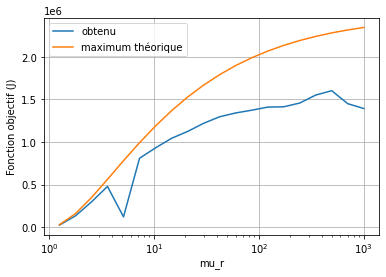

In [12]:
theta_opt = (1-np.sqrt(mur))/(1-mur);
Jopt = pi/mu0 * ((theta_opt/mur + (1-theta_opt)) - 1/(theta_opt*mur+ (1-theta_opt)))

plt.semilogx(mur,-np.array(lastJ),mur,Jopt)
plt.grid()
plt.xlabel('mu_r')
plt.ylabel('Fonction objectif (J)')
plt.legend(['obtenu','maximum théorique'])

In [13]:
mur[-1]

1000.0